# ENRON email classification [scikit-learn]

Giskard is an open-source framework for testing all ML models, from LLMs to tabular models. Don’t hesitate to give the project a [star on GitHub](https://github.com/Giskard-AI/giskard) ⭐️ if you find it useful!

In this notebook, you’ll learn how to create comprehensive test suites for your model in a few lines of code, thanks to Giskard’s open-source Python library.

Use-case:

* Multinomial classification of the email's category.
* Model: `LogisticRegression`
* [Dataset](https://bailando.berkeley.edu/enron/enron_with_categories.tar.gz)

Outline:  

* Detect vulnerabilities automatically with Giskard’s scan
* Automatically generate & curate a comprehensive test suite to test your model beyond accuracy-related metrics
* Upload your model to the Giskard Hub to:  

    * Debug failing tests & diagnose issues
    * Compare models & decide which one to promote
    * Share your results & collect feedback from non-technical team members

## Install dependencies
Make sure to install the `giskard`

In [ ]:
!pip install giskard --upgrade

## Import libraries

In [24]:
import glob
import email
from string import punctuation
from collections import defaultdict

import nltk
import pandas as pd
from dateutil import parser
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn import model_selection
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

from giskard import Dataset, Model, scan, testing, Suite, GiskardClient

## Define constants

In [34]:
TEXT_COLUMN = "Content"
TARGET_COLUMN = "Target"

COLUMN_TYPES = {TEXT_COLUMN: "text"}
COLUMNS_NAMES = ['Target', 'Subject', 'Content', 'Week_day', 'Year', 'Month', 'Hour', 'Nb_of_forwarded_msg']

RANDOM_STATE = 0

IDX_TO_CAT = {
    1: 'REGULATION',
    2: 'INTERNAL',
    3: 'INFLUENCE',
    4: 'INFLUENCE',
    5: 'INFLUENCE',
    6: 'CALIFORNIA CRISIS',
    7: 'INTERNAL',
    8: 'INTERNAL',
    9: 'INFLUENCE',
    10: 'REGULATION',
    11: 'talking points',
    12: 'meeting minutes',
    13: 'trip reports'}

LABEL_CAT = 3

## Dataset preparation

### Load and preprocess data

In [ ]:
!wget https://bailando.berkeley.edu/enron/enron_with_categories.tar.gz
!tar zxf enron_with_categories.tar.gz
!rm enron_with_categories.tar.gz

In [ ]:
nltk.download('punkt')
nltk.download('stopwords')

stoplist = list(set(stopwords.words('english') + list(punctuation)))
stemmer = PorterStemmer()


def get_labels(filename):
    with open(filename + '.cats') as f:
        labels = defaultdict(dict)
        line = f.readline()
        
        while line:
            line = line.split(',')
            top_cat, sub_cat, freq = int(line[0]), int(line[1]), int(line[2])
            labels[top_cat][sub_cat] = freq
            line = f.readline()
            
    return dict(labels)


data = pd.DataFrame(columns=COLUMNS_NAMES)

email_files = [f.replace('.cats', '') for f in glob.glob('enron_with_categories/*/*.cats')]
for email_file in email_files:
    values_to_add = {}

    #Target is the sub-category with maximum frequency
    if LABEL_CAT in get_labels(email_file):
        sub_cat_dict = get_labels(email_file)[LABEL_CAT]
        target_int = max(sub_cat_dict, key=sub_cat_dict.get)
        values_to_add[TARGET_COLUMN] = str(IDX_TO_CAT[target_int])

    #Features are metadata from the email object
    filename = email_file + '.txt'
    with open(filename) as f:

        message = email.message_from_string(f.read())

        values_to_add['Subject'] = str(message['Subject'])
        values_to_add[TEXT_COLUMN] = str(message.get_payload())

        date_time_obj = parser.parse(message['Date'])
        values_to_add['Week_day'] = date_time_obj.strftime("%A")
        values_to_add['Year'] = date_time_obj.strftime("%Y")
        values_to_add['Month'] = date_time_obj.strftime("%B")
        values_to_add['Hour'] = int(date_time_obj.strftime("%H"))

        # Count number of forwarded mails
        number_of_messages = 0
        for line in message.get_payload().split('\n'):
            if ('forwarded' in line.lower() or 'original' in line.lower()) and '--' in line:
                number_of_messages += 1
        values_to_add['Nb_of_forwarded_msg'] = number_of_messages

    row_to_add = pd.Series(values_to_add)
    data = pd.concat([data, pd.DataFrame([row_to_add])], ignore_index=True)


data_filtered = data[data[TARGET_COLUMN].notnull()]

# Exclude target category with very few rows.
excluded_category = [IDX_TO_CAT[i] for i in [11, 12, 13]]
data_filtered = data_filtered[data_filtered["Target"].isin(excluded_category) == False]
num_classes = len(data_filtered[TARGET_COLUMN].value_counts())

# Keep only the email column and the target
data_filtered = data_filtered[[TEXT_COLUMN, TARGET_COLUMN]]

### Train-test split

In [37]:
Y = data_filtered[TARGET_COLUMN]
X = data_filtered.drop(columns=[TARGET_COLUMN])[list(COLUMN_TYPES.keys())]
X_train, X_test, Y_train, Y_test = model_selection.train_test_split(X, Y, random_state=RANDOM_STATE, stratify=Y)

### Wrap dataset with Giskard
To prepare for the vulnerability scan, make sure to wrap your dataset using Giskard's Dataset class. More details [here](https://docs.giskard.ai/en/latest/open_source/scan/scan_nlp/index.html#step-1-wrap-your-dataset).

In [38]:
raw_data = pd.concat([X_test, Y_test], axis=1)
giskard_dataset = Dataset(
    df=raw_data,  # A pandas.DataFrame that contains the raw data (before all the pre-processing steps) and the actual ground truth variable (target).
    target="Target",  # Ground truth variable.
    name="Emails of different categories"  # Optional.
)

## Model building

### Build estimator

In [ ]:
text_transformer = Pipeline([
    ('vect', CountVectorizer(stop_words=stoplist)),
    ('tfidf', TfidfTransformer())
])

preprocessor = ColumnTransformer(
    transformers=[
        ('text_Mail', text_transformer, "Content")
    ]
)

clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', LogisticRegression())])
clf.fit(X_train, Y_train)

print(f"Train Accuracy score: {clf.score(X_train, Y_train):.2f}")
print(f"Test Accuracy score: {clf.score(X_test, Y_test):.2f}")

### Wrap model with Giskard
To prepare for the vulnerability scan, make sure to wrap your model using Giskard's Model class. You can choose to either wrap the prediction function (preferred option) or the model object. More details [here](https://docs.giskard.ai/en/latest/open_source/scan/scan_nlp/index.html#step-2-wrap-your-model).

In [ ]:
giskard_model = Model(
    model=clf,  # A prediction function that encapsulates all the data pre-processing steps and that could be executed with the dataset used by the scan.
    model_type="classification",  # Either regression, classification or text_generation.
    name="Email category classifier",  # Optional.
    classification_labels=clf.classes_.tolist(),  # Their order MUST be identical to the prediction_function's output order.
    feature_names=COLUMN_TYPES.keys(),  # Default: all columns of your dataset.
)

# Validate wrapped model.
y_test_pred_wrapped = giskard_model.predict(giskard_dataset).prediction
wrapped_test_metric = accuracy_score(Y_test, y_test_pred_wrapped)

print(f"Wrapped Test Accuracy score: {wrapped_test_metric:.2f}")

## Detect vulnerabilities in your model

### Scan your model for vulnerabilities with Giskard

Giskard's scan allows you to detect vulnerabilities in your model automatically. These include performance biases, unrobustness, data leakage, stochasticity, underconfidence, ethical issues, and more. For detailed information about the scan feature, please refer to our [scan documentation](https://docs.giskard.ai/en/latest/open_source/scan/scan_nlp/index.html).

In [ ]:
results = scan(giskard_model, giskard_dataset)

In [22]:
display(results)

<iframe id="scan-5513238832" srcdoc="<!doctype html>
<html lang="en">

<head>
 <title>Giskard Scan Results</title>
 <base target="_blank">
 <meta charset="utf-8">
 
<style>pre code.hljs{display:block;overflow-x:auto;padding:1em}code.hljs{padding:3px 5px}
/*!
 Theme: GitHub Dark
 Description: Dark theme as seen on github.com
 Author: github.com
 Maintainer: @Hirse
 Updated: 2021-05-15

 Outdated base version: https://github.com/primer/github-syntax-dark
 Current colors taken from GitHub's CSS
*/.hljs{background:#0d1117;color:#c9d1d9}.hljs-doctag,.hljs-keyword,.hljs-meta .hljs-keyword,.hljs-template-tag,.hljs-template-variable,.hljs-type,.hljs-variable.language_{color:#ff7b72}.hljs-title,.hljs-title.class_,.hljs-title.class_.inherited__,.hljs-title.function_{color:#d2a8ff}.hljs-attr,.hljs-attribute,.hljs-literal,.hljs-meta,.hljs-number,.hljs-operator,.hljs-selector-attr,.hljs-selector-class,.hljs-selector-id,.hljs-variable{color:#79c0ff}.hljs-meta .hljs-string,.hljs-regexp,.hljs-string{color:#a5d6ff}.hljs-built_in,.hljs-symbol{color:#ffa657}.hljs-code,.hljs-comment,.hljs-formula{color:#8b949e}.hljs-name,.hljs-quote,.hljs-selector-pseudo,.hljs-selector-tag{color:#7ee787}.hljs-subst{color:#c9d1d9}.hljs-section{color:#1f6feb;font-weight:700}.hljs-bullet{color:#f2cc60}.hljs-emphasis{color:#c9d1d9;font-style:italic}.hljs-strong{color:#c9d1d9;font-weight:700}.hljs-addition{background-color:#033a16;color:#aff5b4}.hljs-deletion{background-color:#67060c;color:#ffdcd7}.hljs-copy-wrapper{overflow:hidden;position:relative}.hljs-copy-button:focus,.hljs-copy-wrapper:hover .hljs-copy-button{transform:translateX(0)}.hljs-copy-button{background-color:#2d2b57;background-color:var(--hljs-theme-background);background-image:url('data:image/svg+xml;charset=utf-8,<svg xmlns="http://www.w3.org/2000/svg" width="16" height="16" fill="none" viewBox="0 0 24 24"><path fill="%23fff" fill-rule="evenodd" d="M6 5a1 1 0 0 0-1 1v14a1 1 0 0 0 1 1h12a1 1 0 0 0 1-1V6a1 1 0 0 0-1-1h-2a1 1 0 1 1 0-2h2a3 3 0 0 1 3 3v14a3 3 0 0 1-3 3H6a3 3 0 0 1-3-3V6a3 3 0 0 1 3-3h2a1 1 0 0 1 0 2H6Z" clip-rule="evenodd"/><path fill="%23fff" fill-rule="evenodd" d="M7 3a2 2 0 0 1 2-2h6a2 2 0 0 1 2 2v2a2 2 0 0 1-2 2H9a2 2 0 0 1-2-2V3Zm8 0H9v2h6V3Z" clip-rule="evenodd"/></svg>');background-position:50%;background-repeat:no-repeat;border:1px solid #ffffff22;border-radius:.25rem;color:#fff;height:2rem;position:absolute;right:1em;text-indent:-9999px;top:1em;transition:background-color .2s ease,transform .2s ease-out;width:2rem}.hljs-copy-button:hover{border-color:#ffffff44}.hljs-copy-button:active{border-color:#ffffff66}.hljs-copy-button[data-copied=true]{background-image:none;text-indent:0;width:auto}@media (prefers-reduced-motion){.hljs-copy-button{transition:none}}.hljs-copy-alert{clip:rect(0 0 0 0);-webkit-clip-path:inset(50%);clip-path:inset(50%);height:1px;overflow:hidden;position:absolute;white-space:nowrap;width:1px}
/*! tailwindcss v3.3.2 | MIT License | https://tailwindcss.com*/*,:after,:before{border:0 solid #e5e7eb;box-sizing:border-box}:after,:before{--tw-content:""}html{-webkit-text-size-adjust:100%;font-feature-settings:normal;font-family:ui-sans-serif,system-ui,-apple-system,BlinkMacSystemFont,Segoe UI,Roboto,Helvetica Neue,Arial,Noto Sans,sans-serif,Apple Color Emoji,Segoe UI Emoji,Segoe UI Symbol,Noto Color Emoji;font-variation-settings:normal;line-height:1.5;-moz-tab-size:4;-o-tab-size:4;tab-size:4}body{line-height:inherit;margin:0}hr{border-top-width:1px;color:inherit;height:0}abbr:where([title]){-webkit-text-decoration:underline dotted;text-decoration:underline dotted}h1,h2,h3,h4,h5,h6{font-size:inherit;font-weight:inherit}a{color:inherit;text-decoration:inherit}b,strong{font-weight:bolder}code,kbd,pre,samp{font-family:ui-monospace,SFMono-Regular,Menlo,Monaco,Consolas,Liberation Mono,Courier New,monospace;font-size:1em}small{font-size:80%}sub,sup{font-size:75%;line-height:0;position:relative;vertical-align:baseline}sub{bottom:-.25em}sup{top:-.5em}table{border-collapse:col

## Generate comprehensive test suites automatically for your model

### Generate test suites from the scan

The objects produced by the scan can be used as fixtures to generate a test suite that integrate all detected vulnerabilities. Test suites allow you to evaluate and validate your model's performance, ensuring that it behaves as expected on a set of predefined test cases, and to identify any regressions or issues that might arise during development or updates.

In [45]:
test_suite = results.generate_test_suite("My first test suite")
test_suite.run()

Executed 'Invariance to “Add typos”' with arguments {'model': <giskard.models.sklearn.SKLearnModel object at 0x148558f10>, 'dataset': <giskard.datasets.base.Dataset object at 0x14853b8b0>, 'transformation_function': <giskard.scanner.robustness.text_transformations.TextTypoTransformation object at 0x1324c6ec0>, 'threshold': 0.95, 'output_sensitivity': 0.05}: 
               Test failed
               Metric: 0.95
                - [TestMessageLevel.INFO] 213 rows were perturbed
               
Executed 'Precision on data slice “`Content` contains "gives"”' with arguments {'model': <giskard.models.sklearn.SKLearnModel object at 0x148558f10>, 'dataset': <giskard.datasets.base.Dataset object at 0x14853b8b0>, 'slicing_function': <giskard.slicing.slice.QueryBasedSliceFunction object at 0x14c5ba710>, 'threshold': 0.544131455399061}: 
               Test failed
               Metric: 0.29
               
               
Executed 'Precision on data slice “`Content` contains "delay"”' with argum

<TestSuiteResult (failed)>

### Customize your suite by loading objects from the Giskard catalog

The Giskard open source catalog will enable to load:  

* Tests such as metamorphic, performance, prediction & data drift, statistical tests, etc
* Slicing functions such as detectors of toxicity, hate, emotion, etc
* Transformation functions such as generators of typos, paraphrase, style tune, etc

To create custom tests, refer to [this page](https://docs.giskard.ai/en/latest/open_source/customize_tests/test_model/index.html).

For demo purposes, we will load a simple unit test (test_f1) that checks if the test F1 score is above the given threshold. For more examples of tests and functions, refer to the Giskard catalog.

In [ ]:
test_suite.add_test(testing.test_f1(model=giskard_model, dataset=giskard_dataset, threshold=0.7)).run()

## Debug and interact with your tests in the Giskard Hub

At this point, you've created a test suite that is highly specific to your domain & use-case. Failing tests can be a pain to debug, which is why we encourage you to head over to the Giskard Hub.

Play around with a demo of the Giskard Hub on HuggingFace Spaces using [this link](https://huggingface.co/spaces/giskardai/giskard).

More than just debugging tests, the Giskard Hub allows you to:

* Compare models to decide which model to promote
* Automatically create additional domain-specific tests through our automated model insights feature
* Share your test results with team members and decision makers

The Giskard Hub can be deployed easily on HuggingFace Spaces.

Here's a sneak peek of automated model insights on a credit scoring classification model.

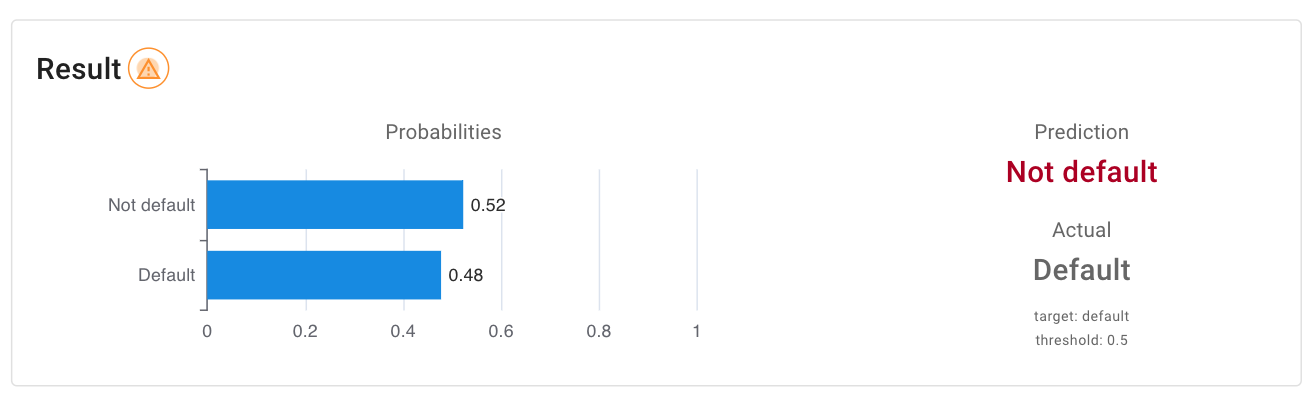

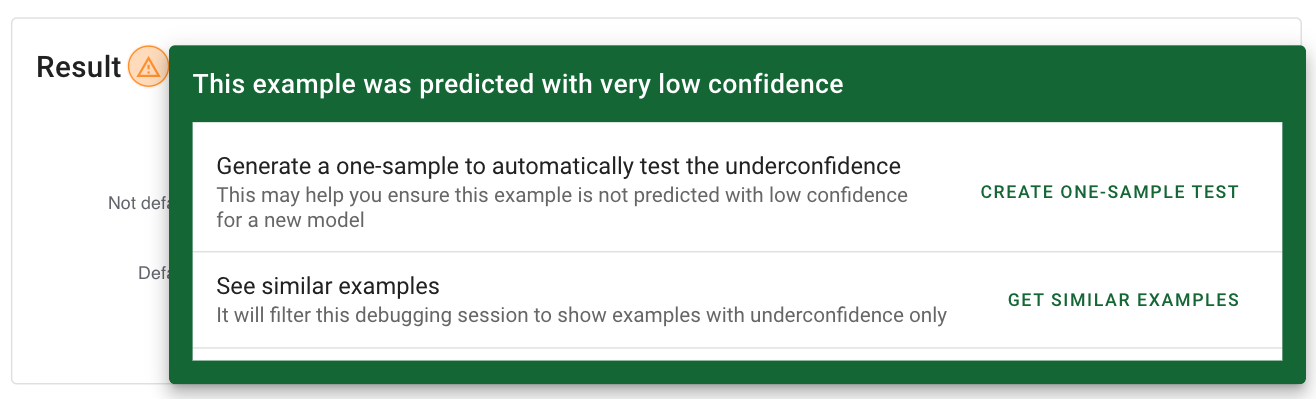

### Upload your test suite to the Giskard Hub

The entry point to the Giskard Hub is the upload of your test suite. Uploading the test suite will automatically save the model, dataset, tests, slicing & transformation functions to the Giskard Hub.

In [ ]:
# Create a Giskard client after having install the Giskard server (see documentation)
api_key = "<Giskard API key>" #This can be found in the Settings tab of the Giskard hub
#hf_token = "<Your Giskard Space token>" #If the Giskard Hub is installed on HF Space, this can be found on the Settings tab of the Giskard Hub

client = GiskardClient(
    url="http://localhost:19000",  # Option 1: Use URL of your local Giskard instance.
    # url="<URL of your Giskard hub Space>",  # Option 2: Use URL of your remote HuggingFace space.
    key=api_key,
    # hf_token=hf_token  # Use this token to access a private HF space.
)

project_key = "my_project"
my_project = client.create_project(project_key, "PROJECT_NAME", "DESCRIPTION")

# Upload to the project you just created
test_suite.upload(client, project_key)

### Download a test suite from the Giskard Hub

After curating your test suites with additional tests on the Giskard Hub, you can easily download them back into your environment. This allows you to:  

- Check for regressions after training a new model
- Automate the test suite execution in a CI/CD pipeline
- Compare several models during the prototyping phase

In [ ]:
test_suite_downloaded = Suite.download(client, project_key, suite_id=...)
test_suite_downloaded.run()